In [1]:
import json
import csv
import keras 
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


%matplotlib inline


c:\users\koki\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
f = open("train/train.json") # Loading the the training dataset
data = json.load(f)
f.close()
type(data) 

x = open("train.csv", 'w+') # Transforming train.json into a csv file
fields = ("id", "cuisine", "ingredients") 
wr = csv.DictWriter(x, fieldnames=fields, lineterminator='\n')
wr.writeheader()
for cases in data:
    wr.writerow({"id": cases['id'], "cuisine": cases['cuisine'], "ingredients": cases['ingredients']})

x.close()

In [3]:
data = pd.read_csv('train.csv', encoding='latin-1')  # Processing the csv file
data.head(n=10)

,id,cuisine,ingredients
0,10259,greek,"['romaine lettuce', 'black olives', 'grape tom..."
1,25693,southern_us,"['plain flour', 'ground pepper', 'salt', 'toma..."
2,20130,filipino,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki..."
3,22213,indian,"['water', 'vegetable oil', 'wheat', 'salt']"
4,13162,indian,"['black pepper', 'shallots', 'cornflour', 'cay..."
5,6602,jamaican,"['plain flour', 'sugar', 'butter', 'eggs', 'fr..."
6,42779,spanish,"['olive oil', 'salt', 'medium shrimp', 'pepper..."
7,3735,italian,"['sugar', 'pistachio nuts', 'white almond bark..."
8,16903,mexican,"['olive oil', 'purple onion', 'fresh pineapple..."
9,12734,italian,"['chopped tomatoes', 'fresh basil', 'garlic', ..."


In [4]:
data.cuisine.value_counts() #number of recipes for each nationality in the dataset

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [5]:
data['target'] = data.cuisine.astype('category').cat.codes #assigning a number to each nationality(target)/ assalphabetical order
data.head(n=20)

,id,cuisine,ingredients,target
0,10259,greek,"['romaine lettuce', 'black olives', 'grape tom...",6
1,25693,southern_us,"['plain flour', 'ground pepper', 'salt', 'toma...",16
2,20130,filipino,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...",4
3,22213,indian,"['water', 'vegetable oil', 'wheat', 'salt']",7
4,13162,indian,"['black pepper', 'shallots', 'cornflour', 'cay...",7
5,6602,jamaican,"['plain flour', 'sugar', 'butter', 'eggs', 'fr...",10
6,42779,spanish,"['olive oil', 'salt', 'medium shrimp', 'pepper...",17
7,3735,italian,"['sugar', 'pistachio nuts', 'white almond bark...",9
8,16903,mexican,"['olive oil', 'purple onion', 'fresh pineapple...",13
9,12734,italian,"['chopped tomatoes', 'fresh basil', 'garlic', ...",9


In [6]:
num_class = len(np.unique(data.cuisine.values)) # Number of all the different nationalities
y = data['target'].values

In [7]:
maxLength = 150
tokenizer = Tokenizer() # vectorize the text corpus - turning each text into a sequence of integers
tokenizer.fit_on_texts(data.ingredients.values)
post_seq = tokenizer.texts_to_sequences(data.ingredients.values)
post_seq_padded = pad_sequences(post_seq, maxlen=maxLength) # Pads sequences to the same length(maxLength)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.1) #Split the data into training and validation data

In [9]:
vocab_size = len(tokenizer.word_index) + 1 #Number of all the ingredients
print(vocab_size)

4732


In [10]:
inputs = Input(shape=(maxLength, ))
embedding_layer = Embedding(vocab_size,64,input_length=maxLength)(inputs) #Turns positive integers (indexes) into dense vectors of fixed size
x = Dropout(0.2)(embedding_layer) #Applies dropout to the input / helps prevent overfitting
x = Flatten()(x) #Flattens the input 
x = Dense(96, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x) # regular densely-connected NN layer + l2 regularization
predictions = Dense(num_class, activation='softmax')(x) # using softmax for  multiclass classification



model = Model(inputs=[inputs], outputs=predictions) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()
filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_best_only=True, mode='max') #Save the model after every epoch
history = model.fit([X_train], batch_size=128, y=to_categorical(y_train), verbose=1, validation_split=0.2, 
          shuffle=True, epochs=25, callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 64)           302848    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                921696    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1940      
Total params: 1,226,484
Trainable params: 1,226,484
Non-trainable params: 0
_________________________________________________________________


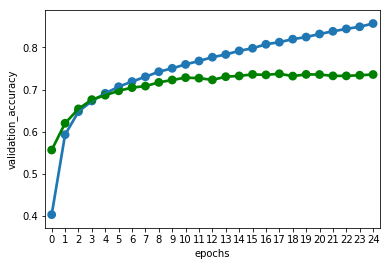

In [11]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
# Visualising training and validation accuracy helps detecting overfitting and/or underfitting

In [12]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.7332830568124685

In [13]:
model.load_weights('weights.hdf5')
predicted = model.predict(X_test)

In [14]:
predicted #Softmax output - each nationality's score(20), the nationality with the highest score is assigned to the recipe

array([[5.6484849e-05, 3.2134396e-06, 9.8431420e-01, ..., 4.5943148e-03,
        1.5111653e-05, 2.1367491e-06],
       [1.4416651e-04, 8.6861188e-03, 1.2512771e-02, ..., 3.7588092e-04,
        1.1966250e-06, 8.2525321e-06],
       [4.7629490e-03, 1.9692758e-05, 2.5391722e-05, ..., 2.5689858e-03,
        1.2519079e-02, 7.0471346e-04],
       ...,
       [9.7701531e-03, 2.0700980e-03, 1.9086283e-01, ..., 7.4739535e-03,
        1.5108841e-03, 6.2164264e-03],
       [1.4873580e-05, 1.9923558e-05, 1.8130342e-04, ..., 1.2867634e-06,
        2.7966481e-03, 5.2342648e-03],
       [1.7414703e-06, 7.9901014e-08, 3.2982725e-06, ..., 1.5086199e-04,
        8.1073871e-08, 7.0301027e-08]], dtype=float32)

In [15]:
targets_cuisines={0:'brazilian',1:'british',2:'cajun_creole',3:'chinese',4:'filipino',5:'french',6:'greek',7:'indian',
                 8:'irish',9:'italian',10:'jamaican',11:'japanese',12:'korean',13:'mexican',14:'maroccan',15:'russian',
                 16:'southern_us',17:'spanish',18:'thai',19:'vietnamese'} #alphabetical order
def finalPrediction(element): #Translates the softmax output into a nationality
    k = np.array(element) 
    z = k.reshape(1,150)
    model.predict(z)
    prediction = np.argmax(model.predict(z)) #Returns the indices of the maximum values along an axis
    cuisine = targets_cuisines[prediction]
    return cuisine

In [16]:
# post_seq_padded contains only examples from train.json 
finalPrediction(post_seq_padded[0]) # 1th element in the dataset, cuisine = greek

'greek'

In [17]:
finalPrediction(post_seq_padded[3])# 4th element in the dataset, cuisine = India

'indian'

In [18]:
finalPrediction(post_seq_padded[4]) # 5th element in the dataset, cuisine = India

'indian'

In [19]:
f = open("test/test.json") # Loading the test dataset
data = json.load(f)
f.close()
type(data)

x = open("test.csv", 'w+') # Converting it into a csv file
fields = ("id", "ingredients")
wr = csv.DictWriter(x, fieldnames=fields, lineterminator='\n')
wr.writeheader()
for cases in data:
    wr.writerow({"id": cases['id'], "ingredients": cases['ingredients']})

x.close()

In [20]:
dataTest = pd.read_csv('test.csv', encoding='latin-1') #Processing test.csv
dataTest.head()

,id,ingredients
0,18009,"['baking powder', 'eggs', 'all-purpose flour',..."
1,28583,"['sugar', 'egg yolks', 'corn starch', 'cream o..."
2,41580,"['sausage links', 'fennel bulb', 'fronds', 'ol..."
3,29752,"['meat cuts', 'file powder', 'smoked sausage',..."
4,35687,"['ground black pepper', 'salt', 'sausage casin..."


In [21]:
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(dataTest.ingredients.values)
post_seq2 = tokenizer.texts_to_sequences(dataTest.ingredients.values)
post_seq_padded2 = pad_sequences(post_seq2, maxlen=maxLength)

In [22]:
model.predict(post_seq_padded2)

array([[1.4677116e-02, 9.7094044e-02, 3.9956807e-03, ..., 1.2186910e-02,
        5.9542077e-04, 2.3903083e-03],
       [2.1792957e-05, 2.6737629e-03, 2.8975619e-02, ..., 4.4218221e-05,
        6.6763187e-07, 1.8295103e-05],
       [7.9919118e-03, 1.1585818e-02, 5.6094024e-03, ..., 6.1465632e-02,
        4.9473805e-04, 3.8763980e-04],
       ...,
       [3.2682656e-04, 2.3210664e-04, 1.1770212e-02, ..., 6.5284609e-03,
        2.1984859e-05, 4.0214290e-05],
       [1.4711107e-04, 3.4296495e-04, 1.7098458e-01, ..., 3.8553946e-04,
        3.1877123e-06, 1.4907466e-05],
       [1.2325410e-04, 4.3816561e-11, 2.0282904e-08, ..., 1.3247619e-06,
        1.3835182e-06, 2.2072554e-06]], dtype=float32)

In [23]:
# Predicting nationality only using the ingredients
# post_seq_padded2 contains all the recipes from test.json

In [24]:
finalPrediction(post_seq_padded2[0]) # predicting the first recipe / this example varies a lot

'italian'

In [25]:
finalPrediction(post_seq_padded2[1]) # predicting the second recipe

'southern_us'

In [26]:
finalPrediction(post_seq_padded2[2]) # predicting the third recipe

'italian'

In [27]:
finalPrediction(post_seq_padded2[10]) #id: 21749 11th recipe

'italian'

In [28]:
finalPrediction(post_seq_padded2[13]) #id: 44883 14th recipe

'italian'